In [1]:
from platform import python_version

print(python_version())


3.10.11


In [2]:
!nvidia-smi

Sat Dec 14 09:25:49 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.99                 Driver Version: 555.99         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   41C    P0             20W /   65W |       0MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# Basic
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

#For synthetic data
from sklearn.datasets import make_blobs

#For Visualisation
import matplotlib.pyplot as plt

#For model selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, accuracy_score

## Understanding SVM using simple synthetic data

Epoch [10/100], Loss: 1.0273
Epoch [20/100], Loss: 0.0803
Epoch [30/100], Loss: 0.0576
Epoch [40/100], Loss: 0.0493
Epoch [50/100], Loss: 0.0453
Epoch [60/100], Loss: 0.0416
Epoch [70/100], Loss: 0.0390
Epoch [80/100], Loss: 0.0371
Epoch [90/100], Loss: 0.0352
Epoch [100/100], Loss: 0.0333
Test Accuracy: 1.0000


C:\Users\saila\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


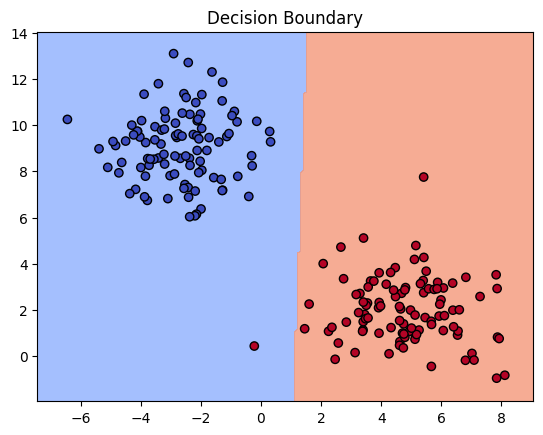

In [4]:
# Generate synthetic data for binary classification
X, y = make_blobs(n_samples=200, centers=2, random_state=42, cluster_std=1.5)
y = y.astype(float)  # PyTorch expects float labels for regression

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a basic linear SVM model
class SVM(nn.Module):
    def __init__(self, input_dim):
        super(SVM, self).__init__()
        self.fc = nn.Linear(input_dim, 1)
        
    def forward(self, x):
        return self.fc(x)

# Instantiate the model
model = SVM(input_dim=X.shape[1])

# Define the loss function (hinge loss for SVM)
def hinge_loss(output, target):
    target = target * 2 - 1  # Convert to -1 and 1
    return torch.mean(torch.clamp(1 - output.squeeze() * target, min=0))

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train).squeeze()
    loss = hinge_loss(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Evaluate on the test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test).squeeze()
    y_pred_labels = (y_pred > 0).float()
    accuracy = (y_pred_labels == y_test).float().mean()
    print(f"Test Accuracy: {accuracy:.4f}")

# Plot decision boundary
def plot_decision_boundary(X, y, model):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = torch.meshgrid(torch.arange(x_min, x_max, 0.1),
                            torch.arange(y_min, y_max, 0.1))
    grid = torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1)
    with torch.no_grad():
        zz = model(grid).squeeze()
    zz = zz.reshape(xx.shape)

    plt.contourf(xx, yy, zz.numpy() > 0, alpha=0.8, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolors='k')
    plt.title("Decision Boundary")
    plt.show()

plot_decision_boundary(X.numpy(), y.numpy(), model)


# SVM over Movie dataset

In [5]:
# Load your dataset
df = pd.read_csv(".\datasets\Movie_regression.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Marketing expense    506 non-null    float64
 1   Production expense   506 non-null    float64
 2   Multiplex coverage   506 non-null    float64
 3   Budget               506 non-null    float64
 4   Movie_length         506 non-null    float64
 5   Lead_ Actor_Rating   506 non-null    float64
 6   Lead_Actress_rating  506 non-null    float64
 7   Director_rating      506 non-null    float64
 8   Producer_rating      506 non-null    float64
 9   Critic_rating        506 non-null    float64
 10  Trailer_views        506 non-null    int64  
 11  3D_available         506 non-null    object 
 12  Time_taken           494 non-null    float64
 13  Twitter_hastags      506 non-null    float64
 14  Genre                506 non-null    object 
 15  Avg_age_actors       506 non-null    int

In [6]:
# Data cleansing

# Fill missing values in "Time_taken" column
df['Time_taken'].fillna(df['Time_taken'].mean(), inplace=True)

# Encode categorical variables (e.g., "Genre" and "3D_available")
label_encoders = {}
for column in ["Genre", "3D_available"]:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

df.head()

,Marketing expense,Production expense,Multiplex coverage,Budget,Movie_length,Lead_ Actor_Rating,Lead_Actress_rating,Director_rating,Producer_rating,Critic_rating,Trailer_views,3D_available,Time_taken,Twitter_hastags,Genre,Avg_age_actors,Num_multiplex,Collection
0,20.1264,59.62,0.462,36524.125,138.7,7.825,8.095,7.910,7.995,7.94,527367,1,109.60,223.840,3,23,494,48000
1,20.5462,69.14,0.531,35668.655,152.4,7.505,7.650,7.440,7.470,7.44,494055,0,146.64,243.456,2,42,462,43200
2,20.5458,69.14,0.531,39912.675,134.6,7.485,7.570,7.495,7.515,7.44,547051,0,147.88,2022.400,1,38,458,69400
3,20.6474,59.36,0.542,38873.890,119.3,6.895,7.035,6.920,7.020,8.26,516279,1,185.36,225.344,2,45,472,66800
4,21.3810,59.36,0.542,39701.585,127.7,6.920,7.070,6.815,7.070,8.26,531448,0,176.48,225.792,2,55,395,72400


# Regression 

In [ ]:
# Separate features and target variables
features = df.drop(columns=["Collection", "Genre"])  # Features
target_regression = df["Collection"]  # Target for regression (box office collection)


# Split dataset into training and test sets
X_train, X_test, y_train_reg, y_test_reg = train_test_split(
    features, target_regression, test_size=0.2, random_state=0
)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train_reg = torch.tensor(y_train_reg.values, dtype=torch.float32)
y_test_reg = torch.tensor(y_test_reg.values, dtype=torch.float32)


# Define the SVM model
class SVM(nn.Module):
    def __init__(self, input_dim):
        super(SVM, self).__init__()
        self.fc = nn.Linear(input_dim, 1)
        
    def forward(self, x):
        return self.fc(x)

# Regression model
svm_reg = SVM(input_dim=X_train.shape[1])
optimizer_reg = optim.SGD(svm_reg.parameters(), lr=0.01)


# Training loop for regression
epochs = 100
for epoch in range(epochs):
    svm_reg.train()
    optimizer_reg.zero_grad()
    outputs = svm_reg(X_train).squeeze()
    loss = criterion_reg(outputs, y_train_reg)
    loss.backward()
    optimizer_reg.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"[Regression] Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


# Evaluation
# Regression
svm_reg.eval()
with torch.no_grad():
    y_pred_reg = svm_reg(X_test).squeeze()
    mse = mean_squared_error(y_test_reg, y_pred_reg)
    print(f"[Regression] Test MSE: {mse:.4f}")

    

# Plot decision boundary
def plot_decision_boundary(X, y, model):
    # Create a grid of points to predict
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    # Flatten the grid and convert to a tensor
    grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

    # Get predictions from the model
    with torch.no_grad():
        predictions = model(grid_points).squeeze().numpy()

    # Reshape predictions back to grid shape
    zz = predictions.reshape(xx.shape)

    # Plot the contour and training points
    plt.contourf(xx, yy, zz > 0, alpha=0.8, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolors='k')
    plt.title("Decision Boundary")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

# Call the function with your data and model
plot_decision_boundary(X_train.numpy(), y_train_reg.numpy(), svm_reg)

## SVM  Regression over Movie dataset

In [ ]:
# Load your dataset
df = pd.read_csv(".\datasets\Movie_regression.csv")

# Data cleansing
# Fill missing values
df.fillna(df.mean(), inplace=True)

# Encode categorical variables (e.g., "Genre" and "3D_available")
label_encoders = {}
for column in ["Genre", "3D_available"]:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Separate features and target variables
features = df.drop(columns=["Collection", "Genre"])  # Features
target_regression = df["Collection"]  # Target for regression (box office collection)
target_classification = df["Genre"]  # Target for classification

# Split dataset into training and test sets
X_train, X_test, y_train_reg, y_test_reg, y_train_clf, y_test_clf = train_test_split(
    features, target_regression, target_classification, test_size=0.2, random_state=0
)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train_reg = torch.tensor(y_train_reg.values, dtype=torch.float32)
y_test_reg = torch.tensor(y_test_reg.values, dtype=torch.float32)
y_train_clf = torch.tensor(y_train_clf.values, dtype=torch.long)  # Classification requires long type
y_test_clf = torch.tensor(y_test_clf.values, dtype=torch.long)

# Define the SVM model
class SVM(nn.Module):
    def __init__(self, input_dim):
        super(SVM, self).__init__()
        self.fc = nn.Linear(input_dim, 1)
        
    def forward(self, x):
        return self.fc(x)

# Regression model
svm_reg = SVM(input_dim=X_train.shape[1])
criterion_reg = nn.MSELoss()
optimizer_reg = optim.SGD(svm_reg.parameters(), lr=0.01)

# Classification model
svm_clf = SVM(input_dim=X_train.shape[1])
criterion_clf = nn.CrossEntropyLoss()  # For classification
optimizer_clf = optim.SGD(svm_clf.parameters(), lr=0.01)

# Training loop for regression
epochs = 100
for epoch in range(epochs):
    svm_reg.train()
    optimizer_reg.zero_grad()
    outputs = svm_reg(X_train).squeeze()
    loss = criterion_reg(outputs, y_train_reg)
    loss.backward()
    optimizer_reg.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"[Regression] Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Training loop for classification
for epoch in range(epochs):
    svm_clf.train()
    optimizer_clf.zero_grad()
    outputs = svm_clf(X_train)
    loss = criterion_clf(outputs, y_train_clf)
    loss.backward()
    optimizer_clf.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"[Classification] Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Evaluation
# Regression
svm_reg.eval()
with torch.no_grad():
    y_pred_reg = svm_reg(X_test).squeeze()
    mse = mean_squared_error(y_test_reg, y_pred_reg)
    print(f"[Regression] Test MSE: {mse:.4f}")

# Classification
svm_clf.eval()
with torch.no_grad():
    y_pred_clf = svm_clf(X_test)
    y_pred_labels = torch.argmax(y_pred_clf, axis=1)
    accuracy = accuracy_score(y_test_clf, y_pred_labels)
    print(f"[Classification] Test Accuracy: {accuracy:.4f}")
